In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from typing import List, Dict
from itertools import groupby

sys.path.append("aux_functions")
from functions_datasets import attert_model as DataBase # define what you import as DataBase!
from functions_datasets import validate_samples 
#from functions_loss import nse_loss, kge_loss
from functions_aux import create_folder, set_random_seed, write_report

Part 1. Initialize information

In [2]:
# paths to access the information
path_entities = 'location_id/location_id_alldata.txt'
path_data = 'attert_model/data_sel_sep'

# dynamic forcings and target
dynamic_input = ['P', 'ET', 'T', 'Q', 'T_10_AVG',
                 'soil_temperature_level_2', 'volumetric_soil_water_layer_2',
                 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation']

target = ['VWC_10_AVG']

# static attributes that will be used
static_input = ['dem', 'x', 'y', 'Skel', 'Sand', 'Silt', 'Clay',
       'landuse_A', 'landuse_B', 'landuse_C', 'landuse_D', 'landuse_E',
       'landuse_F', 'soiltype_A', 'soiltype_B', 'soiltype_C', 'soiltype_D']


# time periods
time_period = 8760
random_state_separation = 1

model_hyper_parameters = {
    "input_size": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 128,
    "hidden_size": 64,
    "batch_size": 128,
    "no_of_epochs": 2,             
    "drop_out": 0.1, 
    "learning_rate": 0.005,
    "adapt_learning_rate_epoch": 1,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3
}

# device to train the model
running_device = 'cpu' #cpu or gpu
# define random seed
seed = 42
# Name of the folder where the results will be stored 
path_save_folder = 'attert_model/results_gauged'

# colorblind friendly palette for plotting
color_palette = {'observed': '#1f78b4','LSTM': '#ff7f00'}

In [3]:
# Create folder to store the results
create_folder(folder_path=path_save_folder)

Folder 'attert_model/results_gauged' already exists.


Part 2. Class to create the dataset object used to manage the information

In [4]:
class BaseDataset(Dataset):

    #Function to initialize the data
    def __init__(self, 
                 dynamic_input: List[str],
                 static_input: List[str],
                 set_type: str,
                 target: List[str], 
                 sequence_length: int,
                 path_entities: str,
                 path_data: str,
                 forcings: List[str] = [],
                 check_NaN:bool = True
                 ):

        # read and create variables
        self.dynamic_input= dynamic_input  # dynamic forcings going as inputs of in the lstm
        self.target = target  # target variable
        self.sequence_length = sequence_length # sequence length
        entities_ids = np.loadtxt(path_entities, dtype='str').tolist() 

        # save the cathments as a list even if there is just one
        self.entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids # catchments

        self.sequence_data = {} # store information that will be used to run the lstm
        self.df_ts = {} # store processed dataframes for all basins
        self.scaler = {} # information to standardize the data 
        self.location_std = {} # std of the target variable of each basin (can be used later in the loss function)
        self.valid_entities= [] # list of the elements that meet the criteria to be used by the lstm
        self.set_type = set_type


        # Process the attributes
        self.static_input = static_input # static attributes going as inputs to the lstm
        if static_input:
            self.df_attributes = self._load_attributes(path_data)



        for id in self.entities_ids:
            # Read files

            df_ts = self._load_data(path_data=path_data, location_id=id, forcings=forcings)
             # Calculate the number of x (selected) - hour elements
            num_segments = len(df_ts) // time_period
             # Create segments of selected hours
            segments = [df_ts.iloc[i * time_period:(i + 1) * time_period].copy() for i in range(num_segments)]
            
            # Add ID_sep column to each segment (it will be beneficial to be able to make a difference between segments)
            for i, segment in enumerate(segments):
                    segment['ID_sep'] = f"{segment['ID'].iloc[0]}_{i+1}"

            all_segments, fixed_test_segments = train_test_split(segments, test_size = 0.2, random_state=25)

            # Now process the data based on set_type
            if set_type == "train":
                segments = all_segments
            elif set_type == "test":
                segments = fixed_test_segments
            else:
                raise ValueError("Invalid set_type. Allowed values are 'train', 'validation', or 'test'.")

            for seg in segments:
                id_sep = seg['ID_sep'].iloc[0]
                id = seg['ID'].iloc[0]
                df_ts = seg

                # Checks for invalid samples due to NaN or insufficient sequence length
                flag = validate_samples(x=df_ts.loc[:, self.dynamic_input].values, 
                                         y=df_ts.loc[:, self.target].values, 
                                         attributes=self.df_attributes.loc[id].values if self.static_input else None, 
                                         seq_length=self.sequence_length,
                                         check_NaN=check_NaN)
            
                # Create a list that contains the indexes (basin, day) of the valid samples
                valid_samples = np.argwhere(flag == 1)
                self.valid_entities.extend([(id_sep, int(f[0])) for f in valid_samples])
            
                # Only store data if this basin has at least one valid sample in the given period
                if valid_samples.size > 0:
                    self.df_ts[id_sep] = df_ts
                
                    # Create dictionary entry for the basin
                    self.sequence_data[id_sep] = {}

                    # Store the information of the basin in a nested dictionary
                    self.sequence_data[id_sep]['x_d'] = torch.tensor(df_ts.loc[:, self.dynamic_input].values, dtype=torch.float32)
                    self.sequence_data[id_sep]['y'] = torch.tensor(df_ts.loc[:, self.target].values, dtype=torch.float32)
                    if self.static_input:
                        self.sequence_data[id_sep]['x_s'] = torch.tensor(self.df_attributes.loc[id].values, dtype=torch.float32)


               
    def __len__(self):
        return len(self.valid_entities)
    
    def __getitem__(self, id):
        """This function is used by PyTorch's dataloader to extract the information"""
        location, i = self.valid_entities[id]

        # tensor of inputs
        x_LSTM = self.sequence_data[location]['x_d'][i-self.sequence_length+1:i+1, :]
        if self.static_input:
            x_s = self.sequence_data[location]['x_s'].repeat(x_LSTM.shape[0],1)
            x_LSTM = torch.cat([x_LSTM, x_s], dim=1)
        
        # tensor of outputs
        y_obs = self.sequence_data[location]['y'][i]

        # optional also return the basin_std
        if self.location_std:
            return x_LSTM, y_obs, self.location_std[location].unsqueeze(0)
        else:
            return x_LSTM, y_obs

    def _load_attributes(self, path_data: str) -> pd.DataFrame:
        """Call the specific function that reads the static attributes information.
        
        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored
            
        Returns
        -------
        df_attributes: pd.DataFrame
            Dataframe containing the attributes of interest for the catchments of interest
        """
        df_attributes = DataBase.read_attributes(path_data=path_data)
        df_attributes = df_attributes.loc[self.entities_ids, self.static_input]
        return df_attributes

    def _load_data(self, path_data: str, location_id:str, forcings:List[str]) -> pd.DataFrame:
        """Call the specific function that reads a specific catchment timeseries into a dataframe.

        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored.
        catch_id : str
            basin_id.
        forcings : str
            Can be e.g. 'daymet' or 'nldas', etc. Must match the folder names in the 'basin_mean_forcing' directory. 

        Returns
        -------
        df: pd.DataFrame
            Dataframe with the catchments` timeseries
        """
        df_ts = DataBase.read_data(path_data=path_data, location_id=location_id, forcings = forcings)
        return df_ts
    
    def calculate_global_statistics(self):
        """Fill the self.scalar dictionary 
        
        The function calculates the global mean and standard deviation of the dynamic inputs, target variables and 
        static attributes, and store the in a dictionary. It will be used later to standardize used in the LSTM. This
        function should be called only in training period. 
        """
        global_x = np.vstack([df.loc[:, self.dynamic_input].values for df in self.df_ts.values()])
        self.scaler['x_d_mean'] = torch.tensor(np.nanmean(global_x, axis=0), dtype=torch.float32)
        self.scaler['x_d_std'] = torch.tensor(np.nanstd(global_x, axis=0), dtype=torch.float32)
        del global_x

        global_y = np.vstack([df.loc[:, self.target].values for df in self.df_ts.values()])
        self.scaler['y_mean'] = torch.tensor(np.nanmean(global_y, axis=0), dtype=torch.float32)
        self.scaler['y_std'] = torch.tensor(np.nanstd(global_y, axis=0), dtype=torch.float32)
        del global_y

        if self.static_input:
            self.scaler['x_s_mean'] = torch.tensor(self.df_attributes.mean().values, dtype= torch.float32)
            self.scaler['x_s_std'] = torch.tensor(self.df_attributes.std().values, dtype= torch.float32)
    
    def standardize_data(self, standardize_output:bool=True):
        """Standardize the data used in the LSTM. 

        The function standardize the data contained in the self.sequence_data dictionary 
        
        Parameters
        ----------
        standardize_output : bool
            Boolean to define if the output should be standardize or not. 
        """
        for location in self.sequence_data.values():
            # Standardize input
            location['x_d'] = (location['x_d'] - self.scaler['x_d_mean']) / self.scaler['x_d_std']
            if self.static_input:
                location['x_s'] = (location['x_s'] - self.scaler['x_s_mean']) / self.scaler['x_s_std']
            # Standardize output
            if standardize_output:
                location['y'] = (location['y'] - self.scaler['y_mean']) / self.scaler['y_std']

Part 3. Create the different datasets

In [5]:
# Dataset training
training_dataset = BaseDataset(dynamic_input=dynamic_input,
                               static_input=static_input,
                               target=target,
                               sequence_length=model_hyper_parameters['seq_length'],
                               path_entities=path_entities,
                               path_data=path_data,
                               set_type='train',
                               check_NaN=True)

#training_dataset.calculate_location_std()
training_dataset.calculate_global_statistics() # the global statistics are calculated in the training period!
training_dataset.standardize_data()

In [6]:
valid_locations_train = [next(group)[0] for key, group in groupby(training_dataset.valid_entities, key=lambda x: x[0])]
print(valid_locations_train)

['M_A_4', 'M_A_3', 'M_E_3', 'M_H_3', 'Sa_B_4', 'Sa_B_3', 'Sa_F_4', 'Sa_F_3', 'Sa_H_3', 'Sa_I_4', 'Sa_I_3', 'Sa_K_4', 'Sa_K_3', 'Sa_L_4', 'Sa_L_3', 'S_A_1', 'S_C_1', 'S_D_4', 'S_D_3', 'S_D_1', 'S_E_4', 'S_E_3', 'S_E_1', 'S_G_1', 'S_J_4', 'S_J_3', 'S_L_1', 'S_M_4', 'S_M_3', 'S_M_1', 'S_Q_4', 'S_Q_3', 'S_Q_1', 'S_R_1', 'S_U_4', 'S_U_3', 'S_U_1', 'S_V_4', 'S_V_3', 'M_C_3', 'M_F_4', 'M_F_3', 'M_G_4', 'M_G_3', 'M_K_3', 'Sa_A_4', 'Sa_A_3', 'Sa_E_4', 'Sa_E_3', 'Sa_G_3', 'Sa_J_4', 'Sa_J_3', 'S_B_3', 'S_B_1', 'S_H_4', 'S_H_3', 'S_H_1', 'S_I_4', 'S_I_3', 'S_I_1', 'S_S_4', 'S_S_3', 'S_T_4', 'S_T_3', 'S_T_1', 'S_W_4', 'S_W_3', 'WB_8_2', 'WB_8_6', 'WB_8_7', 'WB_8_3', 'WB_8_5', 'WB_9_2', 'WB_9_6', 'WB_9_7', 'WB_9_3', 'WB_9_5', 'WB_10_2', 'WB_10_6', 'WB_10_7', 'WB_10_3', 'WB_10_5', 'WB_11_2', 'WB_11_6', 'WB_11_7', 'WB_11_3', 'WB_11_5', 'WB_12_2', 'WB_12_6', 'WB_12_7', 'WB_12_3', 'WB_12_5', 'WB_13_2', 'WB_13_6', 'WB_13_7', 'WB_13_3', 'WB_13_5']


Part 4. Create the different dataloaders

In [7]:
# DataLoader for training data.
train_loader = DataLoader(training_dataset, 
                          batch_size=model_hyper_parameters['batch_size'],
                          shuffle=True,
                          drop_last = True)

print('Batches in training: ', len(train_loader))
x_lstm, y = next(iter(train_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

Batches in training:  5255
x_lstm: torch.Size([128, 128, 26]) | y: torch.Size([128, 1])


Part 5. Define LSTM class

In [8]:
# check if model will be run in gpu or cpu
if running_device == 'gpu':
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == 'cpu':
    device = "cpu"

class Cuda_MDN_LSTM(nn.Module):
    def __init__(self, model_hyper_parameters, num_mixtures=10):
        super().__init__()
        self.num_features = model_hyper_parameters['input_size']
        self.hidden_units = model_hyper_parameters['hidden_size']
        self.num_layers = model_hyper_parameters['no_of_layers']
        self.num_mixtures = num_mixtures

        self.lstm = nn.LSTM(input_size=model_hyper_parameters['input_size'], 
                            hidden_size=model_hyper_parameters['hidden_size'], 
                            batch_first=True,
                            num_layers=model_hyper_parameters['no_of_layers'])

        self.dropout = torch.nn.Dropout(model_hyper_parameters['drop_out'])

        
        self.linear_pi = nn.Linear(in_features=model_hyper_parameters['hidden_size'], out_features=num_mixtures)
        self.linear_mu = nn.Linear(in_features=model_hyper_parameters['hidden_size'], out_features=num_mixtures)
        self.linear_sigma = nn.Linear(in_features=model_hyper_parameters['hidden_size'], out_features=num_mixtures)
           
    def forward(self, x):
        # initialize hidden state with zeros
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, 
                         requires_grad=True, dtype=torch.float32, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, 
                         requires_grad=True, dtype=torch.float32, device=x.device)
        
        out, (hn_1, cn_1) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # sequence to one
        out = self.dropout(out)

        pi = F.softmax(self.linear_pi(out), dim=-1)  # Gumbel softmax
        
        mu = self.linear_mu(out) # Calculating the means of the Gaussian distributions. The linear transformation maps the output to the space of mean values for each Gaussian component
        sigma = torch.exp(self.linear_sigma(out))  # Computing standard deviations of the Gaussian distributions. Using exponential to ensure positivity - requirement for valid Gaussian distributions
        
        return pi, mu, sigma

In [9]:
# Potential loss functions
# 1. Neural hydrology (Gaussian)

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians

def gaussian_distribution(y, mu, sigma):
    """
    Compute the Gaussian probability density function values for given y, mu, and sigma.
    
    Parameters:
    y (Tensor): Target values.
    mu (Tensor): Means of the Gaussian components.
    sigma (Tensor): Standard deviations of the Gaussian components.
    
    Returns:
    Tensor: The probability density values for the Gaussian distribution.
    """

    # Expand y to have the same size as mu, substract mu, and divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)

    # Compute the exponent term of the Gaussian distribution
    result = -0.5 * (result * result)

    # Aooky the Gaussian formula:  exp(-0.5 * ((y - mu) / sigma)^2) / (sigma * sqrt(2 * pi))
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, mu, sigma, y):
    """
    Compute the loss function for a Mixture Density Network (MDN).
    
    Parameters:
    pi (Tensor): Mixing coefficients for the Gaussian components.
    mu (Tensor): Means of the Gaussian components.
    sigma (Tensor): Standard deviations of the Gaussian components.
    y (Tensor): Target values.
    
    Returns:
    Tensor: The mean negative log-likelihood loss for the MDN.
    """

    # Compute the Gaussian probability density function values
    result = gaussian_distribution(y, mu, sigma) * pi

    # Sum the weighted Gaussian densities across all components
    result = torch.sum(result, dim=1)

    # Compute the negative log-likelihood
    result = -torch.log(result)

    # Return the mean loss over all data points
    return torch.mean(result)

# 2. Based on https://deep-and-shallow.com/2021/03/20/mixture-density-networks-probabilistic-regression-for-uncertainty-estimation/

def mdn_gaussian_loss(pi, mu, sigma, y):
    """
    Calculate the loss for Mixture Density Networks.

    Args:
        pi (torch.Tensor): Mixture coefficients, shape (batch_size, num_mixtures).
        mu (torch.Tensor): Means of the Gaussian distributions, shape (batch_size, num_mixtures).
        sigma (torch.Tensor): Standard deviations of the Gaussian distributions, shape (batch_size, num_mixtures).
        target (torch.Tensor): Target values, shape (batch_size,).

    Returns:
        torch.Tensor: Loss value.
    """
    batch_size = y.size(0)
    num_mixtures = pi.size(-1)


    # Reshape target to (batch_size, 1) to enable broadcasting
    y = y.view(-1, 1)

    # Calculate Gaussian PDF
    normal_dist = torch.distributions.Normal(mu, sigma) # initialize normal distribution - a Gaussian distribution is initialized using the means and standard deviations. Creates
                                                        # a Gaussian distribution for each data point in the batch (i.e. each time step)
    probs = normal_dist.log_prob(y) # Calculates the log probability of the target values under each Gaussian distribution

    # Apply log-sum-exp for numerical stability
    exponent = probs + torch.log(pi.unsqueeze(1)) # Log probabilites are weighted by the mixture coefficients (pi). Done by adding the logarithm of the mixture coefficients to the exponent of
                                                    # the log probabilities. The weights are adjusted during training - backpropagation - minimize the loss function
    
    max_exponent, _ = torch.max(exponent, dim=2, keepdim=True) # to ensure numerical stability, the max exponent within each batch is substracted from the exponent before computing
                                                                # the exponential function. Prevents large exponents from causing numerical overflow (results become too large to be represented
                                                                # accurately within the available range of values.

    exponent = exponent - max_exponent

    log_sum_exp = torch.log(torch.sum(torch.exp(exponent), dim=2, keepdim=True)) + max_exponent # Weighted log probabilites are exponentiated, summed across the mixture components and then logged.
                                                                                                # Exponentiation: Exponentiated values represent the unnormalized probabilites associated with each Gaussian component
                                                                                                # Summation: Exponentiated values are summed across the mixture components of each data point in the batch
                                                                                                # - this step computes the total unnormalized probability for each data point
                                                                                                # Logarithm: The operation converts the total unnormalized probability back into log space, yielding the final result


    # Calculate negative log-likelihood
    loss = -torch.mean(log_sum_exp) # Negative log-likelihood is computed as the mean of the log-sum-exp values across the batch

    return loss

# 3. Laplace distributions loss - basically same as 2

def mdn_laplace_loss(pi, mu, b, y):
    """
    Calculate the loss for Mixture Density Networks using Laplace distribution.

    Args:
        pi (torch.Tensor): Mixture coefficients, shape (batch_size, num_mixtures).
        mu (torch.Tensor): Means of the Laplace distributions, shape (batch_size, num_mixtures).
        b (torch.Tensor): Scale parameters of the Laplace distributions, shape (batch_size, num_mixtures).
        target (torch.Tensor): Target values, shape (batch_size,).

    Returns:
        torch.Tensor: Loss value.
    """
    batch_size = y.size(0)
    num_mixtures = pi.size(-1)

    # Reshape target to (batch_size, 1) to enable broadcasting
    y = y.view(-1, 1)

    # Calculate Laplace PDF
    laplace_dist = torch.distributions.Laplace(mu, b)  # initialize Laplace distribution
    probs = laplace_dist.log_prob(y)  # Calculate the log probability of the target values under each Laplace distribution

    # Apply log-sum-exp for numerical stability
    exponent = probs + torch.log(pi.unsqueeze(1))  # Log probabilities are weighted by the mixture coefficients (pi)

    max_exponent, _ = torch.max(exponent, dim=2, keepdim=True)  # Ensure numerical stability

    exponent = exponent - max_exponent

    log_sum_exp = torch.log(torch.sum(torch.exp(exponent), dim=2, keepdim=True)) + max_exponent

    # Calculate negative log-likelihood
    loss = -torch.mean(log_sum_exp)

    return loss

In [10]:
# construct model
set_random_seed(seed=seed)
lstm_model = Cuda_MDN_LSTM(model_hyper_parameters).to(device)

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
lstm_model.lstm.bias_hh_l0.data[model_hyper_parameters['hidden_size']:2 * model_hyper_parameters['hidden_size']]=model_hyper_parameters["set_forget_gate"]

training_time = time.time()


for epoch in range(model_hyper_parameters["no_of_epochs"]):
    epoch_start_time = time.time()

    total_loss = []  # List to store all training losses for the current epoch

    # Training
    lstm_model.train()
    for x_lstm, y in train_loader:
        optimizer.zero_grad()  # reset the gradients of the optimizer before performing backpropagation

        # Perform forward pass of the input through the model
        pi, mu, sigma = lstm_model(x_lstm.to(device).float())

        # Calculate the loss function based on the predicted parameters
        loss = mdn_loss_fn(pi, mu, sigma, y.to(device).float())

        # Perform backpropagation and optimization step to update the weights and biases
        loss.backward()
        optimizer.step()

        # Add current batch loss to total_loss
        total_loss.append(loss.item())

        # Remove from cuda to free up GPU memory
        del y, loss
        torch.cuda.empty_cache()

    # Calculate average loss for the epoch
    average_loss_training = sum(total_loss) / len(train_loader)


    # save model after every epoch
    path_saved_model = path_save_folder+'/epoch_' + str(epoch+1)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    epoch_training_time = time.time()-epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch+1:<2} | Loss training: {"%.3f "% (average_loss_training)} |  LR:{"%.5f "% (LR)} | Training time: {"%.1f "% (epoch_training_time)} s'
    print(report)
    # save epoch report in txt file
    write_report(file_path=path_save_folder+'/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# print total report
total_training_time = time.time()-training_time
report = f'Total training time: {"%.1f "% (total_training_time)} s'
print(report)
# save total report in txt file
write_report(file_path=path_save_folder+'/run_progress.txt', text=report)

Epoch: 1  | Loss training: 0.026  |  LR:0.00500  | Training time: 258.0  s
Epoch: 2  | Loss training: -0.544  |  LR:0.00250  | Training time: 280.1  s
Total training time: 538.2  s


In [11]:
# Assuming pi, sigma, mu are tensors
pi_values = pi.detach().numpy()  # Assuming pi is on GPU, move to CPU and convert to numpy array
sigma_values = sigma.detach().numpy()  # Same for sigma
mu_values = mu.detach().numpy()  # Same for mu

In [13]:

# Assuming pi, sigma, mu are arrays of shape (batch_size, mixture_components)
#batch_size, mixture_components = pi_values.shape

# Generate x values for plotting
#x = np.linspace(-5, 5, 1000)

# Plotting the distributions for each data point in the batch
#for i in range(batch_size):
    #fig, ax = plt.subplots()
    
    # Plot each component distribution
    #for j in range(mixture_components):
        # Compute the Gaussian PDF for the j-th component
        #y = pi_values[i, j] * np.exp(-0.5 * ((x - mu_values[i, j]) / sigma_values[i, j])**2) / (np.sqrt(2 * np.pi) * sigma_values[i, j])
        #ax.plot(x, y, label=f'Component {j+1}')
    
    #ax.set_title(f'Distribution Plot for Data Point {i+1}')
    #ax.legend()
    #ax.set_xlim([-5, 5])
    #plt.show()

Part 7. Test LSTM

In [14]:
# In case I already trained an LSTM I can re-construct the model
#lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
#lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_4'))

In [15]:
# Dataset testing
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           set_type='test',
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False)

test_dataset.scaler = training_dataset.scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_location_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_location_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]

Batches in testing:  54
x_lstm: torch.Size([8633, 128, 26]) | y: torch.Size([8633, 1])


In [16]:
lstm_model.eval()
test_results = {}

with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # Run LSTM
        pi, mu, sigma = lstm_model(x_lstm.to(device).float())

        # Sample from the mixture of Gaussian distributions
        y_sim = torch.sum(pi * mu, dim=-1)

        # Scale back prediction
        y_sim = y_sim * test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # Calculate standard deviation and scale it back
        std_sim = torch.sqrt(torch.sum(pi * (sigma ** 2 + mu ** 2) - (pi * mu) ** 2, dim=-1))
        std_sim = std_sim * test_dataset.scaler['y_std'].to(device)

        # Join results in a DataFrame and store them in a dictionary
        df_ts = test_dataset.df_ts[valid_location_testing[i]].iloc[valid_entity_per_location_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy(),
                                    'st_dev': std_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim', 'st_dev'])
        test_results[valid_location_testing[i]] = df_ts
        
        # Remove from CUDA
        #del x_lstm, y, pi, mu, sigma, y_sim, std_sim
        torch.cuda.empty_cache()

In [17]:
print(valid_location_testing)

['M_A_2', 'M_D_2', 'M_E_2', 'M_H_2', 'M_I_2', 'M_J_2', 'Sa_B_2', 'Sa_C_2', 'Sa_F_2', 'Sa_H_2', 'Sa_I_2', 'Sa_K_2', 'Sa_L_2', 'S_A_2', 'S_C_2', 'S_D_2', 'S_E_2', 'S_G_2', 'S_J_2', 'S_L_2', 'S_M_2', 'S_P_2', 'S_Q_2', 'S_R_2', 'S_U_2', 'S_V_2', 'M_C_2', 'M_F_2', 'M_G_2', 'M_K_2', 'Sa_A_2', 'Sa_E_2', 'Sa_G_2', 'Sa_J_2', 'S_B_2', 'S_F_2', 'S_H_2', 'S_I_2', 'S_O_2', 'S_S_2', 'S_T_2', 'S_W_2', 'WB_8_4', 'WB_8_1', 'WB_9_4', 'WB_9_1', 'WB_10_4', 'WB_10_1', 'WB_11_4', 'WB_11_1', 'WB_12_4', 'WB_12_1', 'WB_13_4', 'WB_13_1']


In [18]:
#import os
# Specify the directory where you want to save the CSV files
#directory = "attert_model/results_fix_test_noera5/1"

# Iterate over the dictionary items
#for key, df in test_results.items():
    # Generate the file name using the key
    #file_name = f"{key}.csv"

    # Create the full file path
    #file_path = os.path.join(directory, file_name)

    # Save the DataFrame to CSV
    #df.to_csv(file_path)

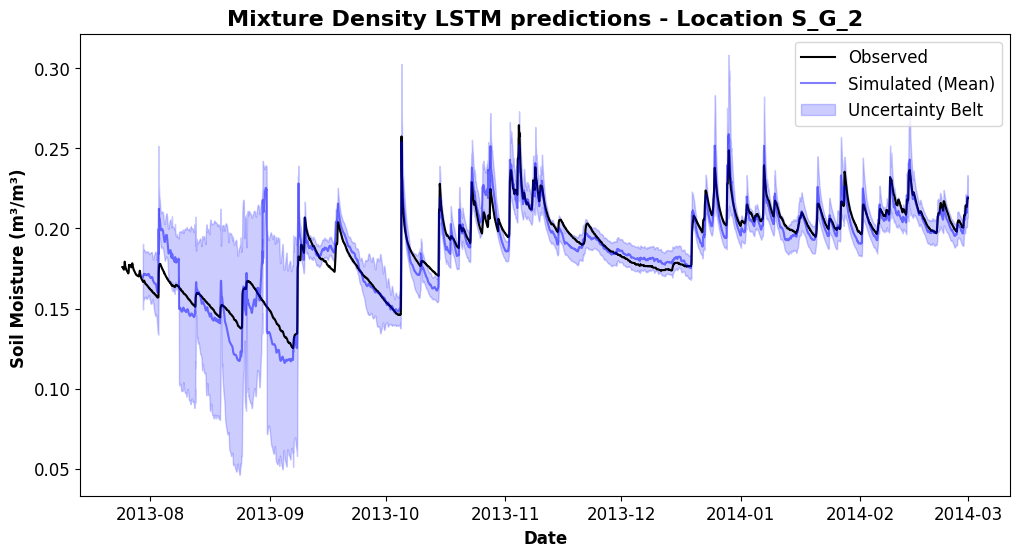

In [19]:
location_to_analyze = 'Sa_I_2'

plt.figure(figsize=(12, 6)) 
plt.plot(test_results[location_to_analyze]['y_obs'], label="Observed", color='black')

# Plot mean of y_sim
plt.plot(test_results[location_to_analyze]['y_sim'], label="Simulated (Mean)", alpha=0.5, color='blue')

# Calculate and plot uncertainty belt (mean ± st_dev)
mean_sim = test_results[location_to_analyze]['y_sim']
std_sim = test_results[location_to_analyze]['st_dev']
plt.fill_between(mean_sim.index, mean_sim - std_sim, mean_sim + std_sim, color='blue', alpha=0.2, label="Uncertainty Belt")

# Format plot
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Soil Moisture (m³/m³) ', fontsize=12, fontweight='bold')
plt.title('Mixture Density LSTM predictions - Location S_G_2', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.show()


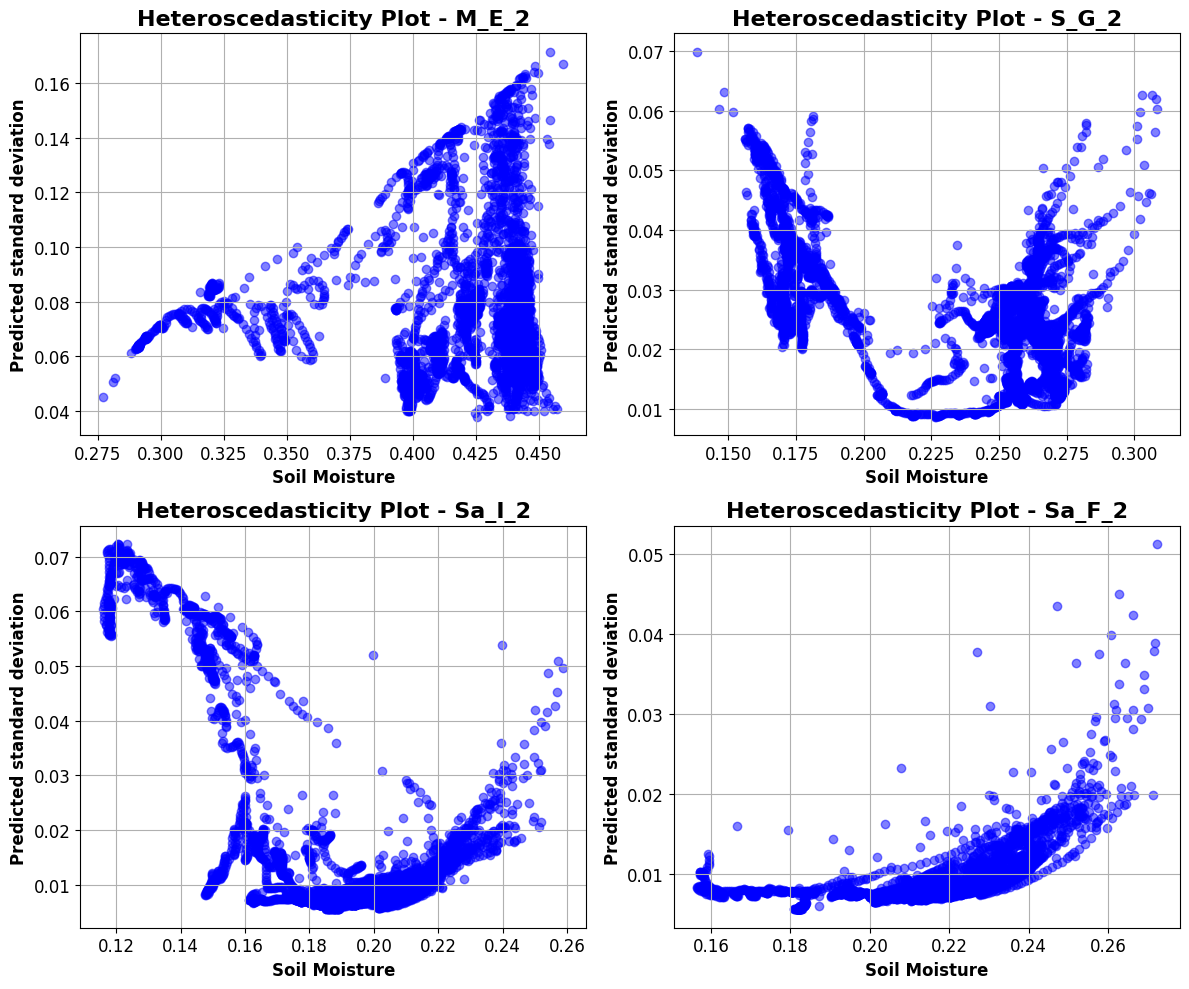

In [20]:
import matplotlib.pyplot as plt

# Define the locations you want to analyze
locations_to_analyze = ['M_E_2', 'S_G_2', 'Sa_I_2', 'Sa_F_2']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over the locations and plot heteroscedasticity for each
for i, location_to_analyze in enumerate(locations_to_analyze):
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    
    soil_moisture = test_results[location_to_analyze]['y_sim']
    std_residuals = test_results[location_to_analyze]['st_dev']
    
    # Save data as CSV
    location_data = pd.DataFrame({'Soil_Moisture': soil_moisture, 'Predicted_Std_Dev': std_residuals})
    #location_data.to_csv(f'{location_to_analyze}_data.csv', index=False)
    
    axs[row, col].scatter(soil_moisture, std_residuals, color='blue', alpha=0.5)
    axs[row, col].set_xlabel('Soil Moisture', fontsize=12, fontweight='bold')
    axs[row, col].set_ylabel('Predicted standard deviation', fontsize=12, fontweight='bold')
    axs[row, col].set_title(f'Heteroscedasticity Plot - {location_to_analyze}', fontsize=16, fontweight='bold')
    axs[row, col].tick_params(axis='both', which='major', labelsize=12)
    axs[row, col].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

# Save the figure
#fig.savefig('heteroscedasticity_plots.png', dpi=300)


Part 8. Initial analysis of the results

In [21]:
locations_to_analyze = valid_location_testing # Replace with your basin names

In [22]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

def kge(observed, simulated):
    valid_indices = ~np.isnan(observed) & ~np.isnan(simulated)
    observed = observed[valid_indices]
    simulated = simulated[valid_indices]

    mean_obs = np.mean(observed)
    mean_sim = np.mean(simulated)
    std_obs = np.std(observed)
    std_sim = np.std(simulated)
    corr = np.corrcoef(observed, simulated)[0, 1]

    kge_val = 1 - np.sqrt((corr - 1) ** 2 + (std_sim / std_obs - 1) ** 2 + (mean_sim / mean_obs - 1) ** 2)

    return kge_val


# Group locations based on prefixes
grouped_locations = {'M_': [], 'S_': [], 'Sa_': [], 'WB_': []}
for location_name in locations_to_analyze:
    for prefix in grouped_locations.keys():
        if location_name.startswith(prefix):
            grouped_locations[prefix].append(location_name)

# Initialize lists to store results
group_labels = []
group_avg_rank_corr = []
group_avg_kge_values = []
individual_results = []

# Loop through groups
for prefix, group_locations in grouped_locations.items():
    group_labels.append(prefix)
    
    # Initialize lists to store individual location metrics in the group
    group_rank_corr = []
    group_kge_values = []

    # Loop through locations in the group
    for location_name in group_locations:
        location_observed = test_results[location_name]['y_obs']
        location_simulated = test_results[location_name]['y_sim']

        # Exclude locations with no values
        if not np.isnan(location_observed).all() and not np.isnan(location_simulated).all():
            # Calculate Spearman rank correlation with handling NaN values
            rank_corr, _ = spearmanr(location_observed, location_simulated, nan_policy='omit')

            # Calculate Kling-Gupta Efficiency (KGE) with handling NaN values
            kge_value = kge(location_observed, location_simulated)

            # Append results to individual location metrics
            individual_results.append({
                'Location': location_name,
                'Spearman Rank Correlation': rank_corr,
                'Kling-Gupta Efficiency (KGE)': kge_value
            })

            # Append results to group metrics
            group_rank_corr.append(rank_corr)
            group_kge_values.append(kge_value)

    # Calculate group averages only if there are valid locations in the group
    if group_rank_corr and group_kge_values:
        avg_rank_corr = np.nanmean(group_rank_corr)
        avg_kge_value = np.nanmean(group_kge_values)
    else:
        avg_rank_corr = np.nan
        avg_kge_value = np.nan

    # Append group averages to the overall lists
    group_avg_rank_corr.append(avg_rank_corr)
    group_avg_kge_values.append(avg_kge_value)

# Create DataFrames for table display
group_avg_df = pd.DataFrame({
    'Location Group': group_labels,
    'Average Spearman Rank Correlation': group_avg_rank_corr,
    'Average KGE': group_avg_kge_values
})

individual_df = pd.DataFrame(individual_results)

# Display the tables
print("Group Averages:")
print(group_avg_df)

print("\nIndividual Location Metrics:")
print(individual_df)


Group Averages:
  Location Group  Average Spearman Rank Correlation  Average KGE
0             M_                           0.777786     0.562371
1             S_                           0.782468     0.539051
2            Sa_                           0.881290     0.774065
3            WB_                           0.803376     0.831284

Individual Location Metrics:
   Location  Spearman Rank Correlation  Kling-Gupta Efficiency (KGE)
0     M_A_2                   0.751457                      0.682184
1     M_D_2                   0.334593                     -0.822588
2     M_E_2                   0.808536                      0.586919
3     M_H_2                   0.915167                      0.648789
4     M_I_2                   0.742961                      0.507241
5     M_J_2                   0.785537                      0.529429
6     M_C_2                   0.759005                      0.844384
7     M_F_2                   0.868696                      0.915198
8     M_

In [125]:
individual_df.to_csv('attert_model/results_fix_test_noera5/1/rs_1_individual.csv')
group_avg_df.to_csv('attert_model/results_fix_test_noera5/1/rs_1_averaged.csv')